In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from wordcloud import WordCloud, STOPWORDS 
import random
import time
import re 
import string
import nltk

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics

from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, log_loss, make_scorer, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pd.options.mode.chained_assignment = None  # default value='warn'

In [2]:
df2 = pd.read_csv('df_clean_text.csv')

In [3]:
df2.head(2)

,complaint_date,product,complaint_narrative,product_id,text_length,complaint_processed,clean_text
0,8/9/2019,"Money transfer, virtual currency, or money ser...","In an attempt to purchase concert tickets, I c...",0,1518,attempt purchase concert tickets communicated ...,attempt purchase concert tickets communicated ...
1,1/27/2020,Credit or prepaid card,In XX/XX/2019 I called Chase to discuss my cre...,1,1467,called discuss credit card bill also close acc...,called chase discuss credit card bill also clo...


In [28]:
df2.shape

(11831, 7)

In [3]:
# Merging some of the product categories and renaming for better understanding
df2.replace({'product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit or prepaid card',
             'Credit card or prepaid card': 'Credit or prepaid card', 
             'Prepaid card': 'Credit or prepaid card',
             'Payday loan, title loan, or personal loan': 'Payday, title, or personal loan',
             'Money transfers': 'Money transfer, virtual currency, or money service',
             'Consumer Loan':'Payday, title, or personal loan',
             'Student loan': 'Payday, title, or personal loan',
             'Vehicle loan or lease':'Payday, title, or personal loan',
              'Bank account or service':'Bank account or other service',
             'Other financial service':'Bank account or other service',
             'Mortgage':'Payday, title, or personal loan',
             'Debt collection': 'Bank account or other service'
              
              
             }},inplace = True)

In [4]:
# checking for unique values in Product column after renaming and combining the values
products = df2.groupby('product').size()
products.sort_values(ascending = False, inplace = True)
print(products)

product
Credit or prepaid card                                4111
Checking or savings account                           3364
Credit reporting, repair, or other                    1636
Payday, title, or personal loan                       1390
Money transfer, virtual currency, or money service     754
Bank account or other service                          576
dtype: int64


In [5]:
# Now mapping each class with specific value for further use
df2['product_id'] = df2['product'].factorize()[0]

In [6]:
# check uinque of product_id column
df2.product_id.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [7]:
tfidf = TfidfVectorizer(sublinear_tf =True, # log form for frequency
                        min_df=5, # minimun number of documents a word must be present
                        use_idf = True, # 
                        norm = u'l2', # set euclidian norm of 1
                        ngram_range = (1,2), # consider unigram and bigram
                        smooth_idf = True, 
                        stop_words = 'english' # remove pronouns, remove noisy features
                       )

# Applying the vectorizer
X = tfidf.fit_transform(df2.clean_text)

In [27]:
X.shape

(11831, 36971)

In [8]:
y = df2['product_id']

In [9]:
# Train Test and Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=44)

In [ ]:
# Global Metrics variable
metrics_models = {'model':[],'accuracy':[],'roc_auc_score':[],'standard deviation':[]}

## A. Random Forest

### Random Forest(base)

              precision    recall  f1-score   support

           0       0.79      0.20      0.32       135
           1       0.77      0.90      0.83       853
           2       0.76      0.88      0.82       674
           3       0.86      0.81      0.84       275
           4       0.77      0.65      0.71       318
           5       0.87      0.18      0.30       112

    accuracy                           0.78      2367
   macro avg       0.80      0.60      0.63      2367
weighted avg       0.78      0.78      0.76      2367

roc_auc_score: 0.914890


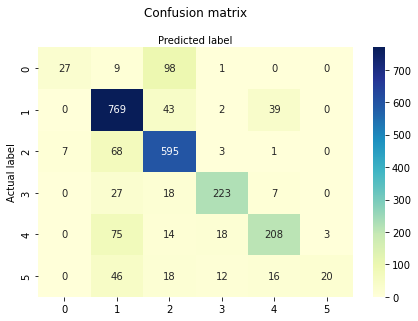

In [42]:
rf_clf = RandomForestClassifier(n_estimators=24, random_state=64)
rf_clf.fit(X_train, y_train)

rf_prediction =rf_clf.predict(X_test)
rf_pred_proba =rf_clf.predict_proba(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, rf_prediction)

class_names=[0,1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,rf_prediction, labels=np.unique(rf_prediction)))

print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, rf_pred_proba, multi_class = 'ovr')))

### Random Forest(tuned)

In [44]:
rft_clf = RandomForestClassifier(random_state=64)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
param_grid = {'n_estimators': range(100,200,5),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[10,15,20],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1,2,4],
               'bootstrap':[True, False]}
rft_grid = GridSearchCV(rft_clf, param_grid= param_grid,
                    cv = cv,
                    n_jobs = -1,
                   verbose = 2)
rft_grid.fit(X_train, y_train)
rft_predict = rft_grid.predict(X_test)
rft_pred_proba =rft_grid.predict_proba(X_test)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


In [46]:
rft_grid.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 185}

[[  0  17 118   0   0   0]
 [  0 808  30   1  14   0]
 [  0  82 592   0   0   0]
 [  0  68  23 180   4   0]
 [  0 146   8  10 154   0]
 [  0  70  18  10   7   7]]
------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.68      0.95      0.79       853
           2       0.75      0.88      0.81       674
           3       0.90      0.65      0.76       275
           4       0.86      0.48      0.62       318
           5       1.00      0.06      0.12       112

   micro avg       0.74      0.78      0.76      2232
   macro avg       0.84      0.61      0.62      2232
weighted avg       0.77      0.78      0.73      2232

Accuracy Score = 0.736
roc_auc_score: 0.936883


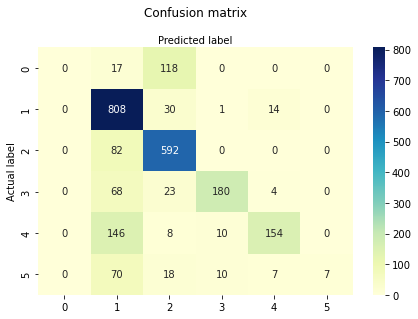

In [49]:
print(confusion_matrix(y_test, rft_predict))
print('------'*10)
print(classification_report(y_test,rft_predict, labels=np.unique(rft_predict)))

cnf_matrix = metrics.confusion_matrix(y_test, rft_predict)

class_names=[0,1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy Score = {:.3f}'.format(metrics.accuracy_score(y_test, rft_predict, sample_weight = None)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, rft_pred_proba, multi_class = 'ovr')))

## B. Logistic Regression

### Logistic Regression(base)

In [13]:
lr_clf = LogisticRegression(solver='lbfgs',max_iter= 200, multi_class='multinomial', random_state = 44)
lr_clf.fit(X_train, y_train)

lr_prediction = lr_clf.predict(X_test)
lr_pred_proba =lr_clf.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.81      0.39      0.52       135
           1       0.84      0.92      0.88       853
           2       0.81      0.91      0.86       674
           3       0.86      0.86      0.86       275
           4       0.74      0.71      0.72       318
           5       0.82      0.25      0.38       112

    accuracy                           0.82      2367
   macro avg       0.81      0.67      0.70      2367
weighted avg       0.82      0.82      0.80      2367

roc_auc_score: 0.950141


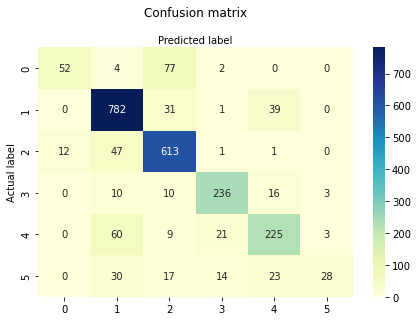

In [14]:
cnf_matrix = metrics.confusion_matrix(y_test, lr_prediction)

class_names=[0,1,2,3,4,5,] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,lr_prediction, labels=np.unique(lr_prediction)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, lr_pred_proba, multi_class = 'ovr')))

### Logistic Regression(tuned)

In [16]:
#time_start = time.time()
lrt_clf = LogisticRegression()
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
param_grid = {
    'penalty': ['l2'],
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs'],
    'multi_class':['multinomial'],
    'max_iter':[500],
    'random_state': [44]
    
}
grid = GridSearchCV(lrt_clf, param_grid = param_grid, cv =5, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)
grid.best_params_
#print('Execution time: {}'.format(time.time() - time_start))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'C': 11.288378916846883,
 'max_iter': 500,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'random_state': 44,
 'solver': 'lbfgs'}

              precision    recall  f1-score   support

           0       0.75      0.51      0.61       135
           1       0.86      0.91      0.88       853
           2       0.82      0.90      0.86       674
           3       0.85      0.85      0.85       275
           4       0.76      0.74      0.75       318
           5       0.72      0.34      0.46       112

    accuracy                           0.83      2367
   macro avg       0.79      0.71      0.74      2367
weighted avg       0.82      0.83      0.82      2367

roc_auc_score: 0.950977


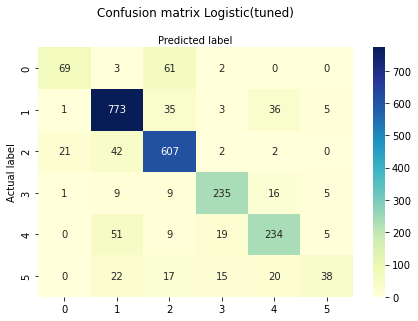

In [17]:
lrt_prediction = grid.predict(X_test)
lrt_pred_proba =grid.predict_proba(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, lrt_prediction)

class_names=[0,1,2,3,4,5,] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic(tuned)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,lrt_prediction, labels=np.unique(lrt_prediction)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, lrt_pred_proba, multi_class = 'ovr')))    

## C. Naive bayes

### Naive bayes(base)

In [18]:
## Training the model wiht naive bayes text classification
nb = MultinomialNB()
nb.fit(X_train,y_train)

# predictions
nb_pred = nb.predict(X_test)
nb_pred_proba = nb.predict_proba(X_test)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.65      0.95      0.78       853
           2       0.75      0.89      0.81       674
           3       0.89      0.48      0.62       275
           4       0.79      0.44      0.56       318

   micro avg       0.71      0.75      0.73      2255
   macro avg       0.62      0.55      0.55      2255
weighted avg       0.69      0.75      0.69      2255

roc_auc_score: 0.910839
Accuracy Score = 0.710


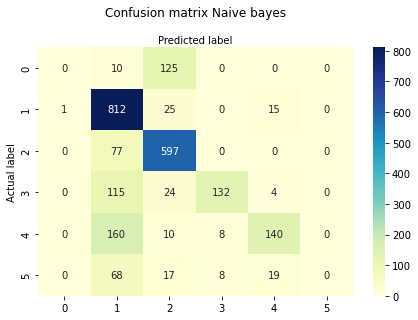

In [20]:
cnf_matrix = metrics.confusion_matrix(y_test, nb_pred)

class_names=[0,1,2,3,4,5,] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Naive bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,nb_pred, labels=np.unique(nb_pred)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, nb_pred_proba, multi_class = 'ovr')))
print('Accuracy Score = {:.3f}'.format(metrics.accuracy_score(y_test, nb_pred, sample_weight = None)))


### Naive bayes(tuned)

In [22]:
nbt = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)

param_grid = {'alpha':[1],
              'class_prior':[None],
              'fit_prior':[True]               
}
grid = GridSearchCV(nbt, param_grid = param_grid, cv =cv, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'alpha': 1, 'class_prior': None, 'fit_prior': True}

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.65      0.95      0.78       853
           2       0.75      0.89      0.81       674
           3       0.89      0.48      0.62       275
           4       0.79      0.44      0.56       318

   micro avg       0.71      0.75      0.73      2255
   macro avg       0.62      0.55      0.55      2255
weighted avg       0.69      0.75      0.69      2255

roc_auc_score: 0.910839
Accuracy Score = 0.710


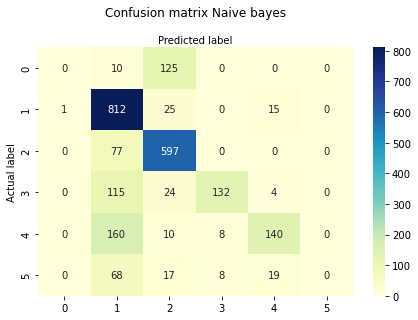

In [24]:
# predictions
nbt_pred = grid.predict(X_test)
nbt_pred_proba = grid.predict_proba(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, nbt_pred)

class_names=[0,1,2,3,4,5,] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Naive bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,nbt_pred, labels=np.unique(nbt_pred)))
print('roc_auc_score: {:3f}'.format(roc_auc_score(y_test, nbt_pred_proba, multi_class = 'ovr')))
print('Accuracy Score = {:.3f}'.format(metrics.accuracy_score(y_test, nbt_pred, sample_weight = None)))

## D. Linear SVC

### Linear SVC(base)

              precision    recall  f1-score   support

           0       0.69      0.51      0.59       135
           1       0.86      0.91      0.88       853
           2       0.83      0.89      0.86       674
           3       0.85      0.87      0.86       275
           4       0.77      0.75      0.76       318
           5       0.73      0.33      0.45       112

    accuracy                           0.83      2367
   macro avg       0.79      0.71      0.73      2367
weighted avg       0.82      0.83      0.82      2367



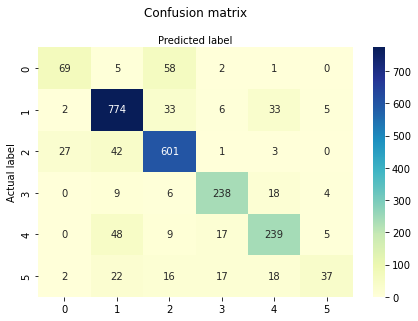

In [26]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc_prediction = svc.predict(X_test) 

#---------------

cnf_matrix = metrics.confusion_matrix(y_test,svc_prediction)

class_names=[0,1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,svc_prediction, labels=np.unique(svc_prediction)))


### Linear SVC(tuned)

In [35]:
svct = LinearSVC()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
param_grid = {
    'penalty': ['l2'],
    'C': np.logspace(1,4,20),
    'multi_class':['ovr'],
    'max_iter':[700,800,1000],
    'random_state': [44]
    
}
grid = GridSearchCV(svct, param_grid = param_grid,
                    cv=cv,
                    n_jobs = -1,
                    verbose = 2
                   )
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'C': 10.0,
 'max_iter': 700,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 44}

              precision    recall  f1-score   support

           0       0.66      0.55      0.60       135
           1       0.85      0.90      0.88       853
           2       0.83      0.86      0.85       674
           3       0.85      0.87      0.86       275
           4       0.76      0.75      0.76       318
           5       0.72      0.38      0.49       112

    accuracy                           0.82      2367
   macro avg       0.78      0.72      0.74      2367
weighted avg       0.82      0.82      0.82      2367



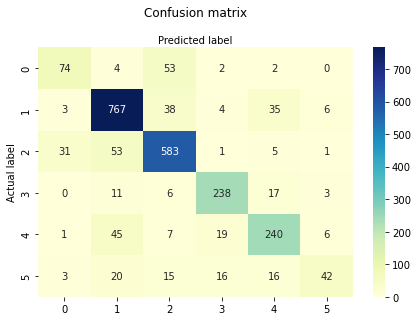

In [38]:
svct_pred = grid.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, svct_pred)

class_names=[0,1,2,3,4,5,] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,svct_pred, labels=np.unique(svct_pred)))

## E. XGBoost

### XGB(base)

              precision    recall  f1-score   support

           0       0.71      0.44      0.54       135
           1       0.84      0.89      0.86       853
           2       0.80      0.88      0.84       674
           3       0.84      0.85      0.85       275
           4       0.73      0.70      0.72       318
           5       0.73      0.37      0.49       112

    accuracy                           0.81      2367
   macro avg       0.78      0.69      0.72      2367
weighted avg       0.80      0.81      0.80      2367

Accuracy Score = 0.807


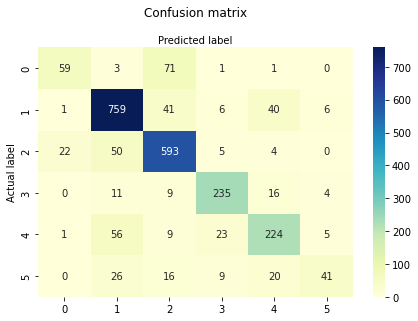

In [11]:

xgb = XGBClassifier(num_class = 6,
                   objective = 'multi:softprob',
                   eval_metric ='mlogloss',
                   use_label_encoder=False,
                   seed =44)

xgb.fit(X_train, y_train)
xgb_prediction = xgb.predict(X_test) 

#---------------

cnf_matrix = metrics.confusion_matrix(y_test, xgb_prediction)

class_names=[0,1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#print(classification_report(y_test,xgb_prediction, labels=np.unique(xgb_prediction)))



### XGB -tuned

In [12]:
xgb = XGBClassifier(num_class = 6,
                   objective = 'multi:softprob',
                   eval_metric ='mlogloss',
                   use_label_encoder=False,
                   seed =44)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # stratified KFold considering imbalanced classes
param_grid = {"max_depth": [10,15,20],
              "n_estimators": range(5,20,5) , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}
grid = GridSearchCV(xgb, param_grid= param_grid,
                    cv = cv,
                    n_jobs = -1,
                    scoring = 'neg_log_loss',
                   verbose = 2)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'gamma': 0.03, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 15}

In [15]:
xgb_pred = grid.predict(X_test)                                   

              precision    recall  f1-score   support

           0       0.58      0.39      0.46       135
           1       0.81      0.86      0.83       853
           2       0.77      0.84      0.80       674
           3       0.81      0.83      0.82       275
           4       0.69      0.68      0.68       318
           5       0.65      0.30      0.41       112

    accuracy                           0.77      2367
   macro avg       0.72      0.65      0.67      2367
weighted avg       0.76      0.77      0.76      2367



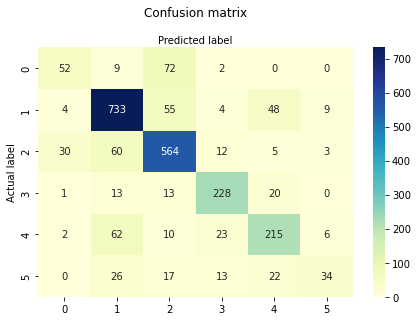

In [18]:
cnf_matrix = metrics.confusion_matrix(y_test, xgb_pred)

class_names=[0,1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(y_test,xgb_pred, labels=np.unique(xgb_pred)))

## Appendix

In [36]:
import sklearn
sklearn.__version__

'1.0.1'